# Prj_GAN (Generative AI)

You have been given a simulated dataset and a pre-trained generative model (see readme.txt).

- The training data is in images.csv and coords.csv.
- The generative model is in WGAN.model.

- Your first task is to use the pre-trained model to generate a new image.
- Your second task is to re-train your own WGAN model using a suitable optimization strategy. For the second task, describe statistics for benchmarking your generative model.


## Task 1: Inference using pre-trained model

### preparing

- import libs as needed
- peek folder structure
- prepare data


In [1]:
# model utils
from generative_model import WGAN_SIMPLE

# paths
import os.path as osp
from glob import glob

# computation
import numpy as np
import pandas as pd
import torch

# graphing
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
DATA_ROOT = '../DATA'
MODEL_ROOT = '../MODEL'
data_paths, model_paths = glob(f'{DATA_ROOT}/*'), glob(f'{MODEL_ROOT}/*')
print(f'data paths: {data_paths}\n'
      f'model paths: {model_paths}')

data paths: ['../DATA/Rayleigh_P30_downsampled_flat.csv', '../DATA/downsampled_points.csv']
model paths: ['../MODEL/WGAN_Simple_epoch199.model']


In [3]:
data = np.genfromtxt(
    f'{DATA_ROOT}/Rayleigh_P30_downsampled_flat.csv', delimiter=',', skip_header=True)
cord = np.genfromtxt(f'{DATA_ROOT}/downsampled_points.csv',
                     delimiter=',', skip_header=True)
avg = np.mean(data, axis=0)
data.shape, avg.shape, cord.shape

((15400, 2382), (2382,), (2382, 2))

### model inference

- load model (in a bit hacky way)
- infer a new distribution


In [13]:
model = WGAN_SIMPLE(ndim=2382, nhid=200)
_ = model.normalize(data)
checkpoint = torch.load(f'{MODEL_ROOT}/WGAN_SIMPLE_epoch199.model')
print(checkpoint.keys(), checkpoint['model_state_dict'].keys())
pretrained_dict = {
    k.replace("model.", ""): v
    for k, v in checkpoint["model_state_dict"].items()
}
model.load_state_dict(pretrained_dict)

dict_keys(['epoch', 'model_state_dict', 'gen_optimizer_state_dict', 'dist_optimizer_state_dict']) odict_keys(['gen.model.0.weight', 'gen.model.0.bias', 'gen.model.3.weight', 'gen.model.3.bias', 'gen.model.6.weight', 'gen.model.6.bias', 'gen.model.9.weight', 'gen.model.9.bias', 'disc.model.0.weight', 'disc.model.0.bias', 'disc.model.2.weight', 'disc.model.2.bias', 'disc.model.4.weight', 'disc.model.4.bias', 'disc.model.6.weight', 'disc.model.6.bias'])


<All keys matched successfully>

In [5]:
with torch.no_grad():
    model.eval()
    fake_data = model.generate()

fake_avg = fake_data.mean(axis=0)
assert fake_avg.shape == avg.shape

### plotting results


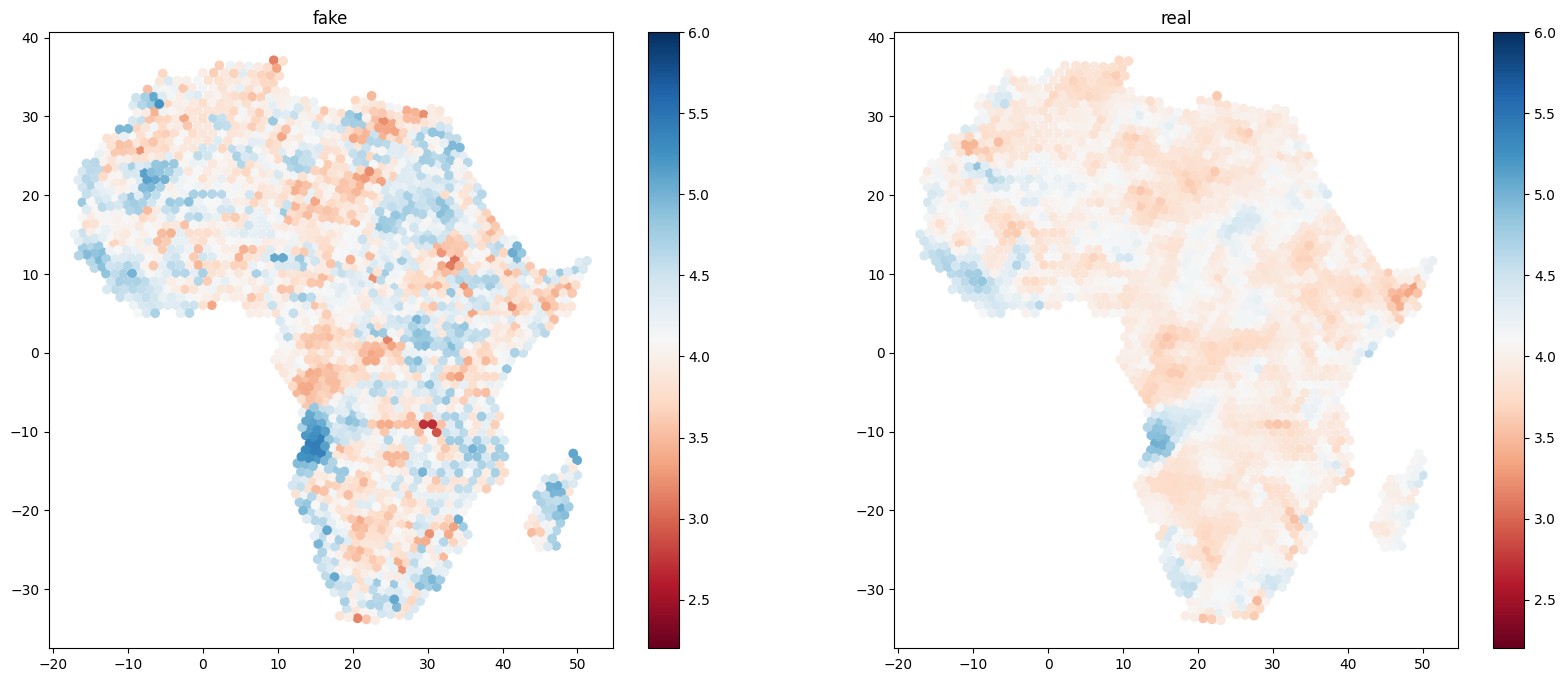

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
axes.flatten()

for _ax, _title, _avg in zip(axes,
                             ('fake', 'real'),
                             (fake_avg, avg)):
    _fig = _ax.scatter(
        cord[:, 0], cord[:, 1],
        vmin=2.2, vmax=6.0,
        c=_avg, cmap='RdBu'
    )
    _ax.set_title(_title)
    plt.colorbar(_fig, ax=_ax)

In [7]:
avg.min(), avg.max(), fake_avg.min(), fake_avg.max()

(3.324581070454339, 5.009031836883052, 2.6913697810000095, 5.425872117214993)

### visualize distribution


<Axes: ylabel='Count'>

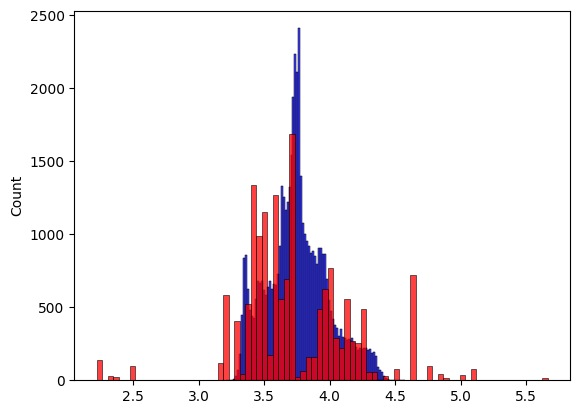

In [8]:
sns.histplot(fake_data[:, 0], color='b')
sns.histplot(data[:, 0], color='r')

(50000,) (15400,)


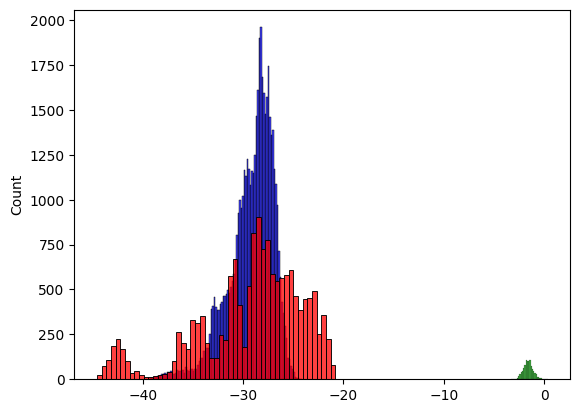

In [9]:
with torch.no_grad():
    model.eval()
    _fake = model.disc(torch.Tensor(fake_data)).numpy().flatten()
    _real = model.disc(torch.Tensor(data)).numpy().flatten()
    _random = model.disc(torch.randn(1000, 2382)).numpy().flatten()
    print(_fake.shape, _real.shape)
    sns.histplot(_fake, color='b')
    sns.histplot(_real, color='r')
    sns.histplot(_random, color='g')